three most common use cases of neural networks:
   - binary classification, 
   - multiclass classification, 
   - and scalar regression

### 4.1 Classifying movie reviews: A binary classification

IMDB dataset: a set of 50,000 highly polarized reviews from the Internet Movie Database. They’re split into 25,000 reviews for training and 25,000 reviews for testing, each set consisting of 50% negative and 50% positive reviews.

In [2]:
from keras.datasets import imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_word=10000)

the argument num_words=10000 means you’ll only keep the top 10,000 most frequently occurring words in the training data. Rare words will be discarded. This allows us to work with vector data of manageable size. If we didn’t set this limit, we’d be working with 88,585 unique words in the training data, which is unnecessarily large. Many of these words only occur in a single sample, and thus can’t be meaningfully used for classification.

The variables train_data and test_data are lists of reviews; each review is a list of word indices (encoding a sequence of words). train_labels and test_labels are lists of 0s and 1s, where 0 stands for negative and 1 stands for positive

In [3]:
>>> train_data[0] 
[1, 14, 22, 16, ... 178, 32] 
>>> train_labels[0] 
1

SyntaxError: invalid syntax. Perhaps you forgot a comma? (2459448173.py, line 2)

For kicks, here’s how you can quickly decode one of these reviews back to English words.

### Listing 4.2 Decoding reviews back to text

In [ ]:
word_index = imdb.get_word_index()
#reverses it, mapping integer indices to words
reverse_word_index = dict(
    [(value,key) for (key,value) in word_index.items()]
)
#decodes the review. é offset de 3 pq 0,1 e 2 sao reservados para
#"padding", "start of sequence", and "uknown"
decoded_review = " ".join(
    [reverse_word_index.get(i - 3, "?") for i in train_data[0]]
)
print(decoded_review)

1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the part's of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole 

### Preparing the data

You can’t directly feed lists of integers into a neural network. You have to turn your lists into tensors. There are two ways to do that:

 - Pad your lists so that they all have the same length, turn them into an integer tensor of shape (samples, max_length), and start your model with a layer capable of handling such integer tensors (the Embedding layer, which we’ll cover in detail later in the book).
  - Multi-hot encode your lists to turn them into vectors of 0s and 1s. This would mean, for instance, turning the sequence [8, 5] into a 10,000-dimensional vector that would be all 0s except for indices 8 and 5, which would be 1s. Then you could use a Dense layer, capable of handling floating-point vector data, as the first layer in your model.

### Encoding the integer sequences via multi-hot encoding 

In [ ]:
import numpy as np
def vectorize_sequences(sequences, dimension=10000):
    #create all-zero matrix 
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        for j in sequence:
            # Only set to 1 if the index is within bounds
            if j < dimension:
                results[i, j] = 1.
    return results

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)


In [ ]:
x_train[0]

array([0., 1., 0., ..., 0., 0., 0.], shape=(10000,))

you should also vectorize your labels:

In [ ]:
y_train = np.asarray(train_labels).astype("float32")
y_test = np.asarray(test_labels).astype("float32")

### 4.1.3 building you model

input data são vectors e labels sao scalars (1,0)

um tipo de modelo que executa num problema de classification é uma pilha de camadas densamente conectadas com ativações relu

There are two key architecture decisions to be made about such a stack of Dense layers:

- how many layers to use
- hoe many units to choose for each layer

neste exemplo serão definidas:
- 2 camadas intermediarias com 16 unidades cada
- uma terceira camada que irá retornar a predição scalar comrelação ao sentiment do review atual

input(vectorized text) -> Dense (units=16) -> Dense (units=16) -> Dense (units=1) -> output(probability)

In [ ]:
from tensorflow import keras
from keras import layers

model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid"),
])

The first argument being passed to each Dense layer is the number of units in the layer: the dimensionality of representation space of the layer. each such Dense layer with a relu activation implements the following chain of tensor operations:

output = relu(dot(input,W) + b)

units =16 significa que o matrix de pesos W terá a shape (input_dimentsion, 16).

a dimensionalidade da representação = quanta liberdade o modelo tem para aprender representações internas

quanto mais unidades (higher dimensional representation space) permite que o modelo aprenda(learn) representações mais complexas, porém faz o modelo mais custoso e poderá aprender padrões indesejados (vai melhorar o training data mas nao o test data)


The intermediate layers use relu as their activation function, and the final layer uses a sigmoid activation so as to output a probability (a score between 0 and 1 indicating how likely the sample is to have the target “1”: how likely the review is to be positive).

 - relu (rectified linear unit) is a function meant to zero out negative values
- sigmoid “squashes” arbitrary values into the [0, 1] interval, outputting something that can be interpreted as a probability

agora escolher uma loss function e um optimizer.

problema = classificação binária de probabilidade, loss function mais apropriada é binary crossentropy

Crossentropy is a quantity from the field of information theory that measures the distance between probability distributions or, in this case, between the ground-truth distribution and your predictions.

As for the choice of the optimizer, we’ll go with rmsprop, which is a usually a good default choice for virtually any problem.

### compilando o modelo

In [ ]:
model.compile(optimizer="rmsprop",
            loss="binary_crossentropy",
            metrics=["accuracy"])

### validando a abordagem


In [ ]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

We will now train the model for 20 epochs (20 iterations over all samples in the training data) in mini-batches of 512 samples. At the same time, we will monitor loss and accuracy on the 10,000 samples that we set apart. We do so by passing the validation data as the validation_data argument.

In [ ]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val)
                )

Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.7886 - loss: 0.5224 - val_accuracy: 0.8615 - val_loss: 0.3940
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8913 - loss: 0.3242 - val_accuracy: 0.8660 - val_loss: 0.3300
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9181 - loss: 0.2425 - val_accuracy: 0.8779 - val_loss: 0.2987
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9314 - loss: 0.1978 - val_accuracy: 0.8857 - val_loss: 0.2834
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9415 - loss: 0.1698 - val_accuracy: 0.8860 - val_loss: 0.2814
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9539 - loss: 0.1414 - val_accuracy: 0.8851 - val_loss: 0.2849
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9595 - loss: 0.1231 - val_accuracy: 0.8831 - val_loss: 0.3106
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9689 - loss: 0.1038 - val_accuracy: 0.8836 - v

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

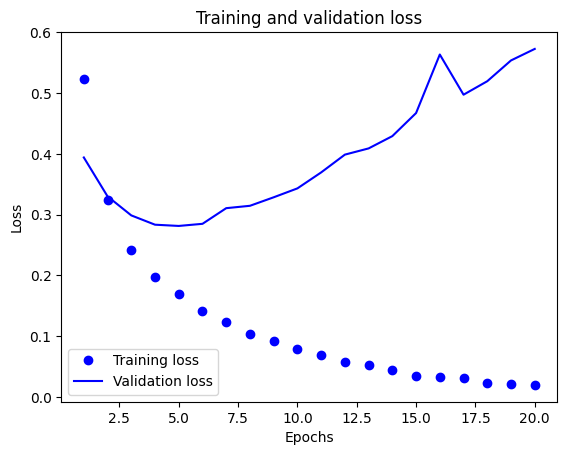

In [ ]:
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


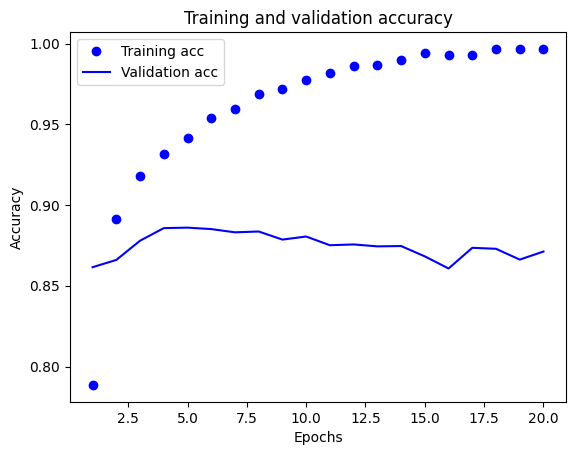

In [ ]:
plt.clf() 
acc = history_dict["accuracy"] 
val_acc = history_dict["val_accuracy"] 
plt.plot(epochs, acc, "bo", label="Training acc") 
plt.plot(epochs, val_acc, "b", label="Validation acc") 
plt.title("Training and validation accuracy") 
plt.xlabel("Epochs") 
plt.ylabel("Accuracy") 
plt.legend() 
plt.show()

podemos ver um caso de overfitting, onde o modelo se desempenha bem nos dados de treinamento, mas não nos de teste.

aprende representações especificas aos dados de treinamento e não são generalizaveis fora do training set

In this case, to prevent overfitting, you could stop training after four epochs. In general, you can use a range of techniques to mitigate overfitting, which we’ll cover in chapter 5.

Let’s train a new model from scratch for four epochs and then evaluate it on the test data.!

### 4.10 Retraining a model from scratch

In [ ]:
model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1,activation="sigmoid")
])
model.compile(optimizer="rmsprop",
            loss="binary_crossentropy",
            metrics=["accuracy"])
model.fit(x_train,y_train,epochs=4,batch_size=512)
results=model.evaluate(x_test, y_test)

Epoch 1/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8156 - loss: 0.4523
Epoch 2/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9032 - loss: 0.2675
Epoch 3/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9239 - loss: 0.2111
Epoch 4/4
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9345 - loss: 0.1817
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8796 - loss: 0.3011


In [ ]:
print(results)

[0.3011320233345032, 0.8795999884605408]


0,30 -> test loss

0,8795 -> test accuracy do modelo

Using trained model to generate predictions on new data

In [4]:
model.predict(x_test)

NameError: name 'model' is not defined